In [1]:
from commons import input_iterator
import pandas as pd
import os
import datetime
import gzip
import glob
import h5py
import numpy as np
from tqdm import tqdm
from pathlib import Path
import shutil
import multiprocessing
from sklearn.metrics import accuracy_score

2022-09-04 02:30:43.793681: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
df_split = pd.read_csv("/mnt/nfs/niddk/ACT_final_randomization_5-13-2019.csv")

test_ids = df_split[df_split['Randomization'] == 'test']['ID']

all_data = glob.glob("/mnt/nfs/niddk/ACT_30HZ_CSV_preprocessed/*/*")

test_files = sorted([x for x in all_data if int(os.path.basename(x)) in set(test_ids)])

out_root = "/mnt/nfs/niddk/ACT_30HZ_CSV_preprocessed_sampled"
shutil.rmtree(out_root, ignore_errors=True)
os.makedirs(out_root)
partition = 8
def apply_fn(x):
    i = x[0]
    test_dir = x[1]
    out_dir = os.path.join(out_root, str(i % partition))
    oid = os.path.basename(test_dir)
    dirname = os.path.dirname(test_dir)
    fnames = [name.split('.')[0] for name in os.listdir(test_dir) if not name.startswith('.')]
    fnames.sort()
    for i in range(len(fnames) - 1):
        assert datetime.datetime.strptime(fnames[i+1], "%Y-%m-%d").date() - datetime.datetime.strptime(fnames[i], "%Y-%m-%d").date() == datetime.timedelta(days=1)
    
    for i, fname in enumerate(fnames):
        h5f = h5py.File(os.path.join(test_dir, '{}.h5'.format(fname)), 'r')
        if i == 0:
            timestamps = h5f.get('time')[:]
            data = h5f.get('data')[:]
            sleeping = h5f.get('sleeping')[:]
            non_wear = h5f.get('non_wear')[:]
            label = h5f.get('label')[:]
        else:
            timestamps = np.concatenate((timestamps, h5f.get('time')[:]))
            data = np.concatenate((data, h5f.get('data')[:]))
            sleeping = np.concatenate((sleeping, h5f.get('sleeping')[:]))
            non_wear = np.concatenate((non_wear, h5f.get('non_wear')[:]))
            label = np.concatenate((label, h5f.get('label')[:]))
    labeld_indices = np.where(label != -1)[0]
    sampled_indices = np.random.choice(labeld_indices, 100, replace=False) 
    interval = 10
    desired = 14 * 60
    first_half = 7 * 60
    need = desired // interval
    for idx in sampled_indices:
        sublabel = label[idx:idx + need]
    #     all labeld and enough
        if sublabel.shape[0] == need and np.where(sublabel == -1)[0].shape[0] == 0:
            for offset in np.array([x for x in range(1, 8)]) * 6 + first_half // interval:
    #             print(offset)
                sub_timestamps = timestamps[idx:idx + offset]
                sub_data = data[idx:idx + offset]
                sub_sleeping = sleeping[idx:idx + offset]
                sub_non_wear = non_wear[idx:idx + offset]
                sub_label = label[idx:idx + offset]
                
                name = "{}_{}_{}".format(oid, idx, offset)
                dummy_name = fnames[0] + '.h5'
                sample_out_dir = os.path.join(out_dir, name)
                Path(sample_out_dir).mkdir(parents=True, exist_ok=True)
                out_filename = os.path.join(sample_out_dir, dummy_name)
                h5f_out = h5py.File(out_filename, "w")
                h5f_out.create_dataset('time', data=sub_timestamps, chunks=True, maxshape=(None,))
                h5f_out.create_dataset('data', data=sub_data, chunks=True, maxshape=(None, 100, 3))
                h5f_out.create_dataset('non_wear', data=sub_non_wear, chunks=True, maxshape=(None,))
                h5f_out.create_dataset('sleeping', data=sub_sleeping, chunks=True, maxshape=(None,))
                h5f_out.create_dataset('label', data=sub_label, chunks=True, maxshape=(None,))
                h5f_out.close()

pool = multiprocessing.Pool(processes=40)
mapped_values = list(tqdm(
    pool.imap_unordered(apply_fn, list(enumerate(test_files))), total=len(test_files)))
pool.close()
pool.join()

    

100%|██████████| 213/213 [23:57<00:00,  6.75s/it]


In [68]:
h5f = h5py.File("/mnt/nfs/niddk/ACT_30HZ_CSV_preprocessed_sampled/7/151667_120933_48/2017-10-23.h5", 'r')

In [71]:
len(h5f.get('label')[:])

27

In [5]:
preds_root = "/mnt/nfs/niddk/ACT_PREDICTIONS_SAMPLED_WRAP/CHAP_ALL_ADULTS"

all_preds = glob.glob(os.path.join(preds_root, "*.csv"))

df_all_sec = pd.DataFrame()
df_all_first = pd.DataFrame()
for predfile in tqdm(all_preds):
    filename = os.path.basename(predfile).split('.')[0]
    oid, index, offset = filename.split("_")
    index = int(index)
    offset = int(offset)
    df = pd.read_csv(predfile)
    df['oid'] = oid
    df['index'] = index
    df['offset'] = offset
    
    df_all_first = pd.concat([df_all_first, df.iloc[:42]], ignore_index=True, sort=False)
    df_all_sec = pd.concat([df_all_sec, df.iloc[42:]], ignore_index=True, sort=False)

#     df_score = df[df['label'] != "no-label"]
#     print(accuracy_score(df_score['label'], df_score['prediction']))

  6%|▋         | 1832/28185 [07:44<1:51:21,  3.94it/s]


KeyboardInterrupt: 

In [6]:
print(accuracy_score(df_all_first['label'], df_all_first['prediction'])) 

0.8320473852388746


In [7]:
print(accuracy_score(df_all_sec['label'], df_all_sec['prediction'])) 

0.842680608365019


In [70]:
df_all_sec['correct'] = df_all_sec['label'] == df_all_sec['prediction']
df_oid_groupby = df_all_sec.groupby(["oid", "offset"]).agg({'correct': "sum", 'index': "count"})
df_oid_groupby['acc'] = df_oid_groupby['correct'] / df_oid_groupby['index']

In [71]:
# df_oid_groupby = df_oid_groupby.reset_index()
df_7 = df_oid_groupby[df_oid_groupby.index.get_level_values(1) == 84]

In [77]:
df_rel = df_oid_groupby.reset_index(level=1).merge(df_7[['acc']], on=['oid'], suffixes=('', '7'))

In [79]:
df_rel['rel_acc'] = df_rel['acc'] / df_rel['acc7']

In [81]:
df_rel.groupby('offset').agg({'acc': "mean", 'rel_acc': "mean"})

,acc,rel_acc
offset,,
48,0.839569,NaN
54,0.848205,NaN
60,0.795652,NaN
66,0.797129,NaN
72,0.846106,NaN
78,0.815014,NaN
84,0.874690,1.0


In [30]:
# df_oid_groupby['rel_acc'] = df_oid_groupby['acc'] / df_7['acc']

In [32]:
df_7['acc']

oid     offset
150011  84        1.000000
150042  84        1.000000
150110  84        1.000000
150298  84        1.000000
150540  84        0.885714
                    ...   
98009   84        1.000000
98230   84        1.000000
98455   84        0.976190
99380   84        1.000000
99423   84        0.988095
Name: acc, Length: 151, dtype: float64

In [31]:
df_oid_groupby

correct  index       acc  rel_acc
oid    offset                                   
150011 66           48     48  1.000000      NaN
       72           30     60  0.500000      NaN
       78           29     36  0.805556      NaN
       84          126    126  1.000000      1.0
150042 48            6      6  1.000000      NaN
...                ...    ...       ...      ...
99423  60           18     18  1.000000      NaN
       66           24     48  0.500000      NaN
       72           30     30  1.000000      NaN
       78           36     36  1.000000      NaN
       84           83     84  0.988095      1.0

[1054 rows x 4 columns]

In [22]:
df_oid_groupby

,oid,offset,correct,index,acc
0,150011,66,48,48,1.000000
1,150011,72,30,60,0.500000
2,150011,78,29,36,0.805556
3,150011,84,126,126,1.000000
4,150042,48,6,6,1.000000
...,...,...,...,...,...
1049,99423,60,18,18,1.000000
1050,99423,66,24,48,0.500000
1051,99423,72,30,30,1.000000
1052,99423,78,36,36,1.000000


In [17]:
df_7

,oid,offset,correct,index
3,150011,84,126,126
9,150042,84,42,42
14,150110,84,42,42
19,150298,84,84,84
28,150540,84,186,210
...,...,...,...,...
1027,98009,84,84,84
1030,98230,84,42,42
1036,98455,84,82,84
1047,99380,84,42,42


In [53]:
offsets = sorted(df_all_sec["offset"].unique())

accs = {}
for off in offsets:
    df_score = df_all_sec[df_all_sec['offset'] == off]
    minute = (off - 42) // 6
    acc = accuracy_score(df_score['label'], df_score['prediction'])
    accs[minute] = acc

In [64]:
import matplotlib
import matplotlib.font_manager
from matplotlib import pyplot as plt
import seaborn as sns
class PlotterBase(object):
    def __init__(
            self,
            xlabel=None,
            ylabel=None,
            title=None,
            set_ticks=False,
            figsize=(5, 5)):
        self.fig, self.ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
        self.ax.set_xlabel(xlabel)
        self.ax.set_ylabel(ylabel)
        self.ax.set_title(title)
        self.set_ticks = set_ticks

    def plot(self, x, *args, **kwargs):
        self.ax.plot(x, linewidth=2, *args, **kwargs)
        if self.set_ticks:
            self.ax.set_xticks(x)

    def conclude(self, loc=None):
        self.ax.legend(ncol=2, loc=loc)
        self.fig.tight_layout()

    def save(self, path):
        save_fig(self.fig, path)
# font = {'size': 14}
# matplotlib.rc('font', **font)
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rc('pdf', fonttype=42)


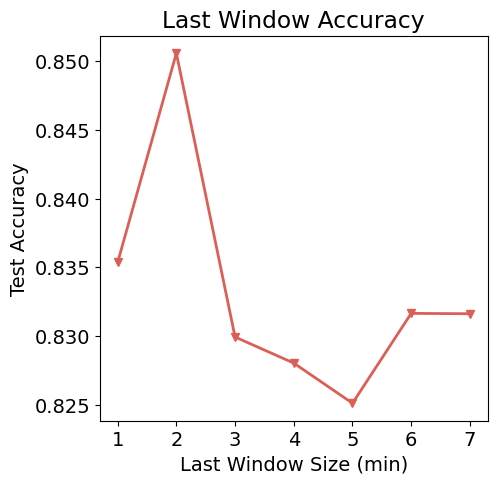

In [67]:
xs = sorted(list(accs.keys()))
ys = [accs[x] for x in xs]

palette = sns.color_palette("hls", 2)
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=palette)
line_fmts = ['v-', '^-']
plot_e2e = PlotterBase(xlabel='Last Window Size (min)',
                       ylabel='Test Accuracy',
                       title='Last Window Accuracy',
                       set_ticks=True)
plot_e2e.plot(xs, ys, line_fmts[0], color=palette[0], ms=6, label="wrap")
# save_fig(plot_e2e.fig, "./figures/throughput_scaling_model_batch_default_gc")

In [29]:
df.iloc[:42]

,segment,timestamp,label,prediction,oid,index,offset
0,0,2018-02-15 00:28:10,sitting,sitting,156996,69289,78
1,0,2018-02-15 00:28:20,sitting,sitting,156996,69289,78
2,0,2018-02-15 00:28:30,sitting,sitting,156996,69289,78
3,0,2018-02-15 00:28:40,sitting,sitting,156996,69289,78
4,0,2018-02-15 00:28:50,sitting,sitting,156996,69289,78
5,0,2018-02-15 00:29:00,sitting,sitting,156996,69289,78
6,0,2018-02-15 00:29:10,sitting,sitting,156996,69289,78
7,0,2018-02-15 00:29:20,sitting,sitting,156996,69289,78
8,0,2018-02-15 00:29:30,sitting,sitting,156996,69289,78
9,0,2018-02-15 00:29:40,sitting,sitting,156996,69289,78


In [27]:
df_all

,segment,timestamp,label,prediction,oid,index,offset
0,0,2017-05-12 19:11:10,not-sitting,not-sitting,156554,11227,84
1,0,2017-05-12 19:11:20,not-sitting,not-sitting,156554,11227,84
2,0,2017-05-12 19:11:30,not-sitting,not-sitting,156554,11227,84
3,0,2017-05-12 19:11:40,not-sitting,not-sitting,156554,11227,84
4,0,2017-05-12 19:11:50,not-sitting,not-sitting,156554,11227,84
...,...,...,...,...,...,...,...
52015,0,2018-02-15 00:40:20,sitting,sitting,156996,69289,78
52016,0,2018-02-15 00:40:30,sitting,sitting,156996,69289,78
52017,0,2018-02-15 00:40:40,sitting,sitting,156996,69289,78
52018,0,2018-02-15 00:40:50,sitting,sitting,156996,69289,78


In [24]:
predfile.split("_")

['/mnt/nfs/niddk/ACT',
 'PREDICTIONS',
 'SAMPLED',
 'WRAP/CHAP',
 'ALL',
 'ADULTS/156554',
 '11227',
 '84.csv']

0.6246209877743695

In [11]:
df

,segment,timestamp,label,prediction
0,0,2018-04-02 00:00:00,no-label,sitting
1,0,2018-04-02 00:00:10,no-label,sitting
2,0,2018-04-02 00:00:20,no-label,sitting
3,0,2018-04-02 00:00:30,no-label,sitting
4,0,2018-04-02 00:00:40,no-label,sitting
...,...,...,...,...
120955,0,2018-04-15 23:59:10,no-label,sitting
120956,0,2018-04-15 23:59:20,no-label,sitting
120957,0,2018-04-15 23:59:30,no-label,sitting
120958,0,2018-04-15 23:59:40,no-label,sitting


In [3]:
data = list(input_iterator("/mnt/nfs/niddk/ACT_30HZ_CSV_preprocessed/1", "152570"))

In [7]:
data[0]

(array([[[ 0.534, -0.686,  0.443],
         [ 0.535, -0.687,  0.441],
         [ 0.533, -0.687,  0.443],
         ...,
         [ 0.535, -0.683,  0.444],
         [ 0.534, -0.687,  0.442],
         [ 0.535, -0.685,  0.443]],
 
        [[ 0.537, -0.689,  0.443],
         [ 0.537, -0.689,  0.443],
         [ 0.537, -0.689,  0.443],
         ...,
         [ 0.537, -0.689,  0.443],
         [ 0.537, -0.689,  0.443],
         [ 0.537, -0.689,  0.443]],
 
        [[ 0.537, -0.689,  0.443],
         [ 0.537, -0.689,  0.443],
         [ 0.537, -0.689,  0.443],
         ...,
         [ 0.537, -0.689,  0.443],
         [ 0.537, -0.689,  0.443],
         [ 0.537, -0.689,  0.443]],
 
        ...,
 
        [[ 0.419,  0.018,  0.906],
         [ 0.419,  0.018,  0.906],
         [ 0.419,  0.018,  0.906],
         ...,
         [ 0.419,  0.018,  0.906],
         [ 0.419,  0.018,  0.906],
         [ 0.419,  0.018,  0.906]],
 
        [[ 0.419,  0.018,  0.906],
         [ 0.419,  0.018,  0.906],
       

In [16]:
downsample_window=1.0/10
cnn_window_size = 10
gt3x_frequency = 30

RESOLUTION = 1/float(10)
GT3X_FREQUENCY = gt3x_frequency
CNN_WINDOW_SIZE = 10

In [32]:
label_map = json.loads('{"0": 0, "1": 1, "2": 1}')

In [66]:
ap_df = pd.read_csv(os.path.join(
                '/mnt/nfs/niddk/ACT_EVENTS', '{}.csv'.format("152570")))
ap_df['Time'] = ap_df['Time'].map(
            lambda x: datetime.datetime.utcfromtimestamp(round((x - 25569.) * 86400 * 10) / 10.))
event_start_times = ap_df['Time'].tolist()
ap_df['Interval (s)'] = ap_df['Interval (s)'].map(
    lambda x: datetime.timedelta(seconds=round(x * 10) / 10.))
event_intervals = ap_df['Interval (s)'].tolist()
# Fix for column name inconsistency in ActivPal
ap_df = ap_df.rename(columns={
                     'ActivityCode (0=sedentary, 1= standing, 2=stepping)': 'ActivityCode (0=sedentary, 1=standing, 2=stepping)'})
event_labels = ap_df['ActivityCode (0=sedentary, 1=standing, 2=stepping)'].apply(
    lambda x: label_map[str(x)]).tolist()

In [68]:
event_start_times[-100:]

[Timestamp('2017-07-06 06:49:30'),
 Timestamp('2017-07-06 06:49:35.800000'),
 Timestamp('2017-07-06 06:49:48.700000'),
 Timestamp('2017-07-06 06:49:50'),
 Timestamp('2017-07-06 06:49:51.400000'),
 Timestamp('2017-07-06 06:49:52.600000'),
 Timestamp('2017-07-06 06:49:57'),
 Timestamp('2017-07-06 06:59:45.100000'),
 Timestamp('2017-07-06 06:59:46.400000'),
 Timestamp('2017-07-06 06:59:47.700000'),
 Timestamp('2017-07-06 06:59:49.100000'),
 Timestamp('2017-07-06 06:59:50.400000'),
 Timestamp('2017-07-06 06:59:51.800000'),
 Timestamp('2017-07-06 06:59:54.300000'),
 Timestamp('2017-07-06 06:59:55.600000'),
 Timestamp('2017-07-06 06:59:56.900000'),
 Timestamp('2017-07-06 06:59:58.400000'),
 Timestamp('2017-07-06 07:00:45.500000'),
 Timestamp('2017-07-06 07:00:47'),
 Timestamp('2017-07-06 07:00:48.500000'),
 Timestamp('2017-07-06 07:00:49.900000'),
 Timestamp('2017-07-06 07:00:51.400000'),
 Timestamp('2017-07-06 07:00:52.800000'),
 Timestamp('2017-07-06 07:00:54.300000'),
 Timestamp('2017-07-

In [21]:
ap_df

,Time,DataCount (samples),Interval (s),"ActivityCode (0=sedentary, 1= standing, 2=stepping)",CumulativeStepCount,Activity Score (MET.h),Abs(sumDiff)
0,42914.333183,0,7310.5,0,0,2.538368,4608
1,42914.417795,73105,1.9,1,0,0.000739,272
2,42914.417817,73124,3.2,2,1,0.001967,344
3,42914.417854,73156,4.9,2,2,0.002628,490
4,42914.417911,73205,1.2,2,3,0.001189,126
...,...,...,...,...,...,...,...
33489,42922.747802,7270231,0.8,2,28951,0.001033,215
33490,42922.747811,7270239,0.3,1,28951,0.000117,18
33491,42922.747815,7270242,321387.8,0,28951,111.593000,97037
33492,42926.467581,10484120,0.9,1,28951,0.000350,265


In [56]:
fin = gzip.open("/mnt/nfs/niddk/ACT_30HZ_CSV/1/152570.csv.gz", mode="rt")

values = []
gt3x_file = fin
gt3x_lines = [gt3x_file.readline().rstrip() for _ in range(11)]
start_time = gt3x_lines[3][11:].strip() + " " + gt3x_lines[2][11:].strip()
current_time = datetime.datetime.strptime(
    start_time + " UTC", "%m/%d/%Y %H:%M:%S %Z")
unflushed_start_date = current_time.date()
pointer = 0

In [59]:
def check_label(pointer, check_time):
    if ap_df is None:
        return pointer, -1

    while pointer < len(event_start_times):
        if check_time < event_start_times[pointer]:
            return pointer, -1
        if event_start_times[pointer] <= check_time <= event_start_times[pointer] + event_intervals[pointer]:
            return pointer, event_labels[pointer]

        pointer += 1
    return pointer, -1

In [60]:
pointer

0

In [62]:
event_start_times[pointer]

Timestamp('2017-06-28 07:59:47')

In [61]:
current_time

datetime.datetime(2017, 6, 28, 0, 0)

In [ ]:
while True:
    lines = []
    while len(lines) < int(GT3X_FREQUENCY * RESOLUTION):
        l = gt3x_file.readline().rstrip()
        if len(l) == 0:
            break
        lines.append(l)

    if len(lines) < int(GT3X_FREQUENCY * RESOLUTION):
        break

    acc = np.array([[float(x) for x in l.split(',')] for l in lines])
    acc = np.mean(acc, axis=0)
    pointer, label = check_label(pointer, current_time)
    values.append([current_time, acc[0], acc[1], acc[2], check_non_wear(
        subject_id, current_time), check_sleeping(subject_id, current_time), label])

    current_time = current_time + timedelta(seconds=RESOLUTION)

In [57]:
current_time

datetime.datetime(2017, 6, 28, 0, 0)

In [53]:
gt3x_lines

['------------ Data File Created By ActiGraph GT3X+ ActiLife v6.13.3 Firmware v3.2.1 date format M/d/yyyy at 30 Hz  Filter Normal -----------',
 'Serial Number: NEO1F08120254',
 'Start Time 00:00:00',
 'Start Date 6/28/2017',
 'Epoch Period (hh:mm:ss) 00:00:00',
 'Download Time 12:43:25',
 'Download Date 7/21/2017',
 'Current Memory Address: 0',
 'Current Battery Voltage: 3.91     Mode = 12',
 '--------------------------------------------------',
 'Accelerometer X,Accelerometer Y,Accelerometer Z']

In [ ]:
x, timestamps, labels = [d[0].reshape(-1, int(1/downsample_window * cnn_window_size),
                                          int(gt3x_frequency*downsample_window), 1) for d in data], [d[1] for d in data], [d[2] for d in data]